In [1]:
# globa library
from pandas import read_csv, DataFrame, to_datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

c:\Users\jsgaleano\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# Dataframe
df_datagen = read_csv('../DataGeneración_filo.csv')

In [3]:
print(df_datagen.head())

                 Fecha        kWh
0  2021-01-01 00:00:00  353483.09
1  2021-01-01 01:00:00  387809.23
2  2021-01-01 02:00:00  385176.88
3  2021-01-01 03:00:00  372592.99
4  2021-01-01 04:00:00  368292.48


In [4]:
df_datagen.index = to_datetime(df_datagen['Fecha'])
del df_datagen['Fecha']


In [5]:
print(df_datagen.head())

                           kWh
Fecha                         
2021-01-01 00:00:00  353483.09
2021-01-01 01:00:00  387809.23
2021-01-01 02:00:00  385176.88
2021-01-01 03:00:00  372592.99
2021-01-01 04:00:00  368292.48


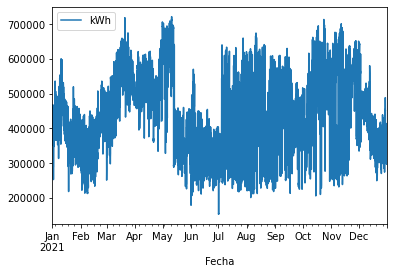

In [6]:
df_datagen.plot()

In [7]:
df_datagen_day = df_datagen.resample("d").mean()

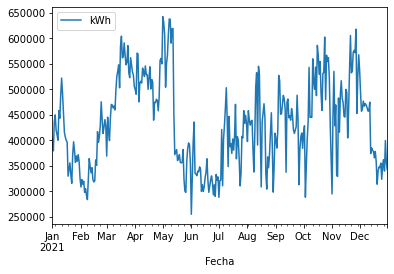

In [8]:
df_datagen_day.plot()

# Stationarity

In [9]:
rolling_mean = df_datagen_day.rolling(7).mean()
rolling_std = df_datagen_day.rolling(7).std()

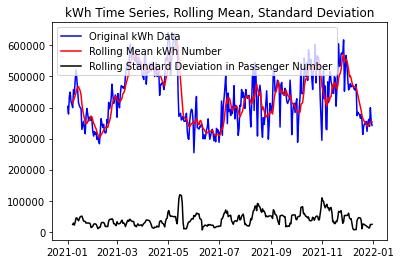

In [10]:
plt.plot(df_datagen_day, color="blue",label="Original kWh Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean kWh Number")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in Passenger Number")
plt.title("kWh Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")

In [11]:
adft = adfuller(df_datagen_day,autolag="AIC")

In [12]:
output_df = DataFrame(
        {"Values":[
            adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']
            ], 
        "Metric":["Test Statistics","p-value","No. of lags used",
        "Number of observations used", 
        "critical value (1%)", "critical value (5%)", "critical value (10%)"]
        }
    )

In [13]:
output_df

,Values,Metric
0,-2.879825,Test Statistics
1,0.047745,p-value
2,4.000000,No. of lags used
3,360.000000,Number of observations used
4,-3.448646,critical value (1%)
5,-2.869602,critical value (5%)
6,-2.571065,critical value (10%)


# Autocorrelation

In [14]:
autocorrelation_lag1 = df_datagen_day['kWh'].autocorr(lag=1)
print("One Day Lag: ", autocorrelation_lag1)

One Day Lag:  0.8342909421320023


In [15]:
day=3
autocorrelation_lag9 = df_datagen_day['kWh'].autocorr(lag=day)
print(f"{day} Day Lag: ", autocorrelation_lag9)

3 Day Lag:  0.6968223579754946


# Decomposition

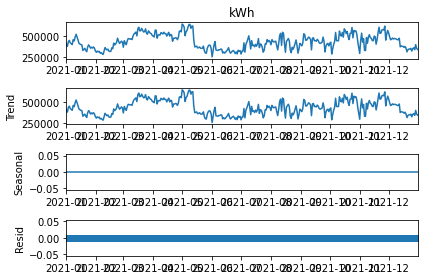

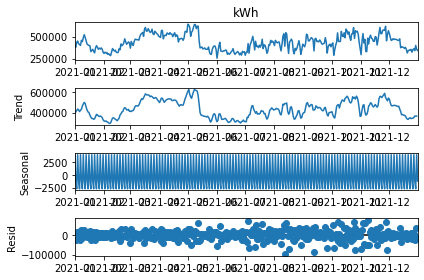

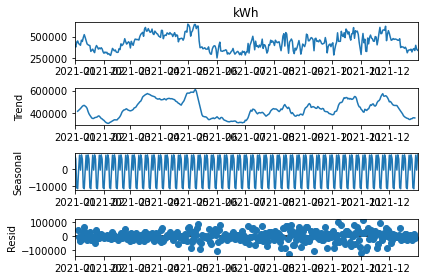

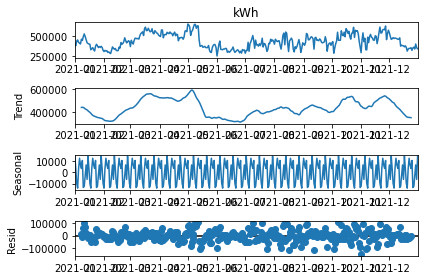

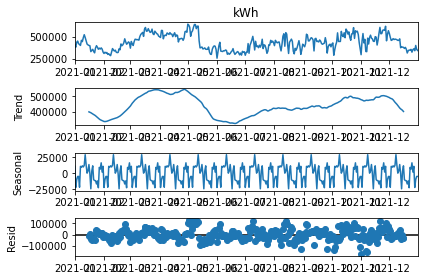

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

periodos = [1,3,7,14,30]
for periodo in periodos:
    decompose = seasonal_decompose(df_datagen_day['kWh'],model='additive', period=periodo )
    decompose.plot()
    #plt.title('Seasonal Decomposition for:' + str(periodo/24) + ' dias')
    plt.show()

# Forecasting

<ipython-input-27-131d046b28a1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['kWh']
<ipython-input-27-131d046b28a1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['kWh']


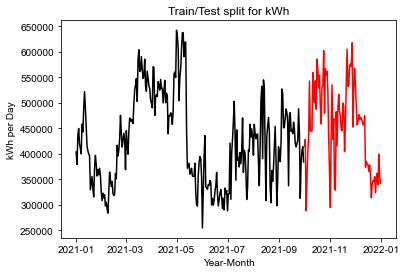

In [27]:
import pandas as pd
import seaborn as sns
df_datagen_day['Date'] = df_datagen_day.index
train = df_datagen_day[df_datagen_day['Date'] < pd.to_datetime("2021-10", format='%Y-%m')]
train['train'] = train['kWh']
del train['Date']
del train['kWh']
test = df_datagen_day[df_datagen_day['Date'] >= pd.to_datetime("2021-10", format='%Y-%m')]
del test['Date']
test['test'] = test['kWh']
del test['kWh']
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for kWh")
plt.ylabel("kWh per Day")
plt.xlabel('Year-Month')
sns.set()
plt.show()

In [57]:
from pmdarima.arima import auto_arima

model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True,method='nm',
 m=52, stepwise=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=6983.705, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6722.487, Time=1.23 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=6782.741, Time=1.14 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=7862.873, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=6618.630, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=6620.463, Time=0.92 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=6619.275, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=6617.444, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=6649.521, Time=1.20 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=6619.232, Time=1.12 sec
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=6788.538, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[52] intercept

In [58]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  91961.69347426212


In [59]:
forecast.head()

,Prediction
Fecha,
2021-10-01,388365.589430
2021-10-02,396325.452646
2021-10-03,397740.482164
2021-10-04,399079.787836
2021-10-05,400347.421945


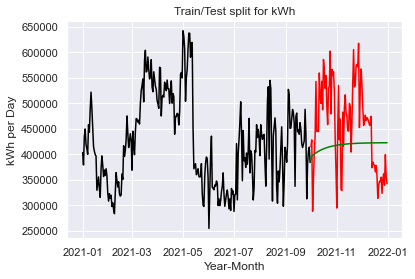

In [60]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast, color = "green")
plt.title("Train/Test split for kWh")
plt.ylabel("kWh per Day")
plt.xlabel('Year-Month')
sns.set()
plt.show()

c:\Users\jsgaleano\Anaconda3\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


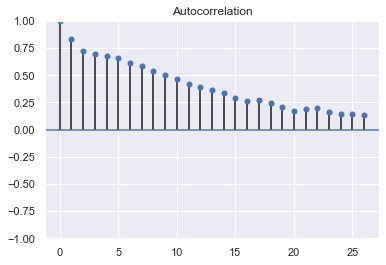

In [54]:
import pmdarima as pm
pm.plot_acf(df_datagen_day.kWh)

In [55]:
from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(df_datagen_day.kWh)  # (0.01, False)

In [56]:
p_val

0.25008460596113313